In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
wine_df = pd.read_csv('Wine.csv')
wine_df.shape

(178, 13)

# Outlier Treatment

In [3]:
import numpy as np
feature=['Malic_Acid','Ash','Ash_Alcanity','Magnesium','Proanthocyanins','Color_Intensity','Hue']
for i in feature:
    Q1=np.percentile(wine_df[i], 25, interpolation='midpoint')
    Q2=np.percentile(wine_df[i], 50, interpolation='midpoint')
    Q3=np.percentile(wine_df[i], 75, interpolation='midpoint')
    IQR=Q3-Q1
    low_lim=Q1-1.5*IQR
    up_lim=Q3+1.5*IQR
    filt_for_del=(wine_df[i]>up_lim) | (wine_df[i]<low_lim)
    slice_for_del=wine_df.loc[filt_for_del,:]
    index_to_del=slice_for_del.index
    index_to_del_list = index_to_del.to_list()
    wine_df.drop(index_to_del_list, inplace=True)

In [4]:
wine_df.shape

(161, 13)

In [5]:
from sklearn import preprocessing
X=preprocessing.normalize(wine_df)
X=pd.DataFrame(X)
X.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000
mean,0.019901,0.003643,0.003620,0.030667,0.149208,0.003396,0.002937,0.000573,0.002307,0.007234,0.001471,0.003983,0.986361
std,0.007458,0.002338,0.001403,0.014559,0.054661,0.001545,0.001724,0.000324,0.001201,0.003520,0.000733,0.001999,0.010238
min,0.008428,0.000944,0.001473,0.009800,0.064147,0.001255,0.000637,0.000145,0.000554,0.002241,0.000579,0.001675,0.951812
25%,0.013438,0.001687,0.002353,0.017452,0.104447,0.002376,0.001742,0.000276,0.001468,0.004708,0.000969,0.002521,0.982112
50%,0.018566,0.003196,0.003437,0.029500,0.143578,0.002916,0.002724,0.000511,0.001970,0.005984,0.001192,0.003381,0.988987
75%,0.024834,0.004940,0.004466,0.039810,0.180956,0.003795,0.003549,0.000834,0.002779,0.008564,0.001827,0.004866,0.994260
max,0.041106,0.011903,0.007305,0.069703,0.297958,0.008404,0.008671,0.002008,0.007469,0.020690,0.004727,0.010858,0.997835


# PCA

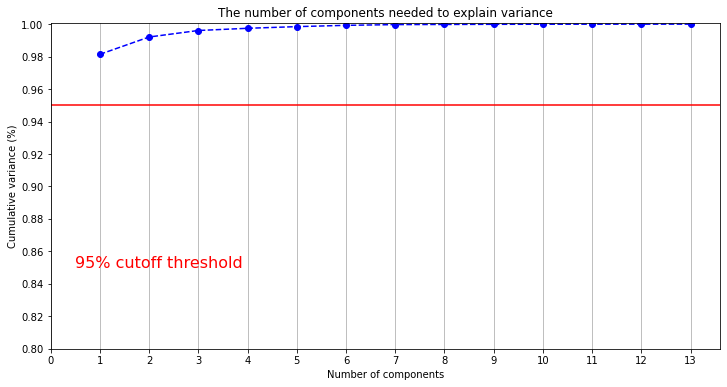

In [15]:
from sklearn.decomposition import PCA
pca = PCA().fit(X)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1,14,step=1)
y= np.cumsum(pca.explained_variance_ratio_)


plt.ylim = (0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color = 'b')
plt.xlabel('Number of components')
plt.xticks(np.arange(0,14,step=1))
#plt.yticks([0.8,1],step=0.5)
ax.yaxis.set_ticks(np.linspace(0.8,1,11))  
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cutoff threshold', color = 'red', fontsize = 16)

ax.grid(axis='x')
plt.show()

**Surprisingly, we see a 0.98 variance being explained by 1 component. Though strange, we will create a model to find the number of clusters, but we will perform the PCA transformation using 2 components**

In [16]:
pca = PCA(n_components = 2)
pca.fit(X)
x_pca = pca.transform(X)
x_pca.shape

(161, 2)

# KMeans

C:\Users\Dilip\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


0.5383337226892307
0.18736756031312746
0.08711546958955305
0.04701869925044197
0.02905348903149718
0.021659586526918326
0.017469930137289327
0.01487757369882859
0.012685689211091308
0.011438839698677003


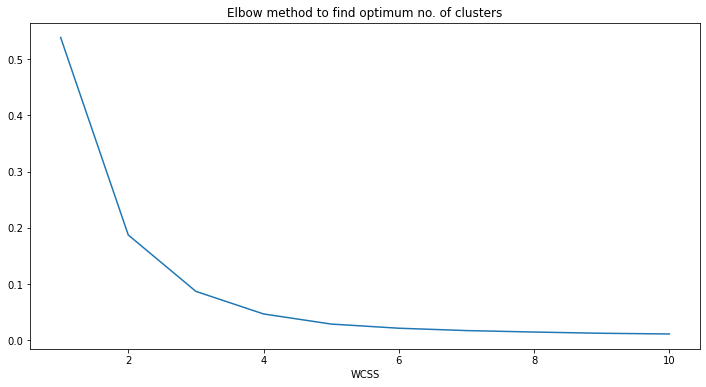

In [17]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(x_pca)
    wcss.append(kmeans.inertia_)
    print(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow method to find optimum no. of clusters')
plt.xlabel('WCSS')
plt.show()

**The number of clusters as shown by the PCA method for normalized data is 3; let us proceed to create the model:**

In [18]:
kmeans=KMeans(n_clusters=3, init='k-means++', random_state=42)
y_means=kmeans.fit_predict(x_pca)
Categ_df=pd.DataFrame(data=y_means,columns=["Category"])
KMeansFinal_df=wine_df.join(Categ_df)

In [19]:
KMeansFinal_df['Category'].value_counts()

0.0    62
2.0    56
1.0    27
Name: Category, dtype: int64

**Here, we see a different result from that obtained by using Standard Scaling, as far as Counts go.**

# AHC

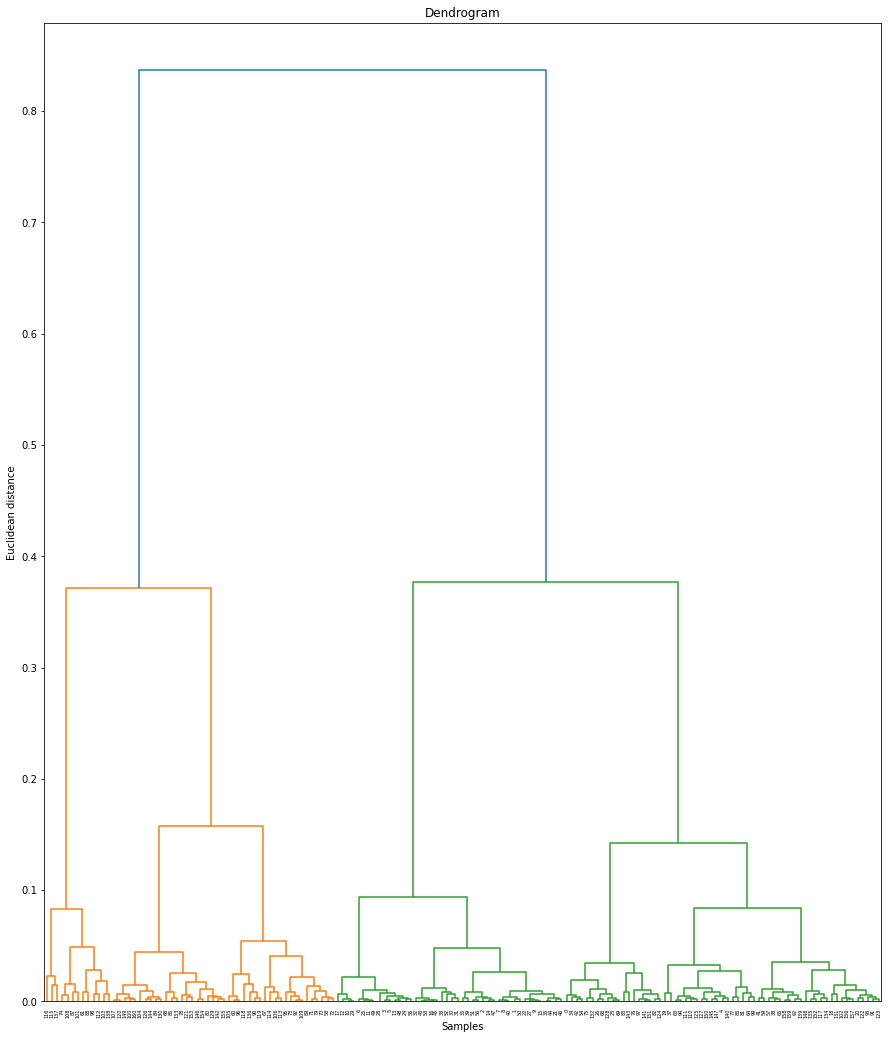

In [20]:
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(15,18))
dendrogram = sch.dendrogram(sch.linkage(x_pca, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Euclidean distance')
#plt.hlines(0.5,0,5000, colors="r", linestyles="dashed")
#plt.hlines(0.08,0,5000, colors="r", linestyles="dashed")
plt.show()

In [21]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
y_hc = hc.fit_predict(x_pca)
CategHC_2_df=pd.DataFrame(data=y_hc,columns=["Category_HC_2"])
Final_HC_2_df=wine_df.join(CategHC_2_df)
Final_HC_2_df["Category_HC_2"].value_counts()

0.0    95
1.0    50
Name: Category_HC_2, dtype: int64